In [1]:
import datetime
# import talib
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import requests
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import math
import _pickle as cPickle
sys.path.insert(0, '../model_structure')
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = '../extraction/eb_target/bert_token_WMT.pkl'
csv_path = "DCNN_Final_more2.csv"
model_path = '../models/model.pt'
model_path_last = '_last.pt'.join(model_path.split('.pt'))

config = {
    'learning_rate': 0.001,
    'weight_decay': 1e-7,
    'batch_size': 32,
    'n_epochs': 100,
}


device = get_device()
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
# # Prepare Dataset
class EssayDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        # if self.y is not None:
        return self.X[index], self.y[index]

        # else:
        #     return self.a0[index], self.p[index], self.a1[index]

    def __len__(self):
        return self.n_samples

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
# T
with open(csv_path, "w") as f:
    f.write(f'ticker,channels,train_acc,val_acc,test_acc,size\n')
def normalize(x):
    return ((x - x.min()) / (
            x.max() - x.min()))  # .values


def stationary(x):
    return (x / x.shift(1) - 1)




with open(rf"../embeddings/transformer/y.pickle", "rb") as input_file:
    y = cPickle.load(input_file)
y_df = y
encoding = {}
elements = {
    "leo":0,
    "aries":0,
    "sagittarius":0,
    "cancer":1,
    "scorpio":1,
    "pisces": 1,
    "gemini":2,
    "libra": 2,
    "aquarius":2,
    "taurus": 3,
    "virgo": 3,
    "capricorn": 3
}
for i in range(len(y.unique())):
    encoding[y.unique()[i]] = i
def label_encode(x):
    # return math.sqrt(x)
    return encoding[x]
def element_encode(x):
    # return math.sqrt(x)
    return elements[x]
y = np.array(list(map(label_encode, y_df)))


False


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC



def load_data(file_name, col_name, log_path = '../output/output.txt'):
    """
    Read in input file and load data

    root_dir: a path for data directory
    datafile: a text file for saving output

    return: X and y dataframe
    """
    output_file = open(log_path, 'a')

    df = pd.read_csv(file_name)
    print("\n********** Data Summary **********\n")
    print(df.shape, "\n")
    print(df.head(3), "\n")
    print(df.info(), "\n")

    print("\n********** Data Summary **********\n", file=output_file)
    print(df.shape, "\n", file=output_file)
    print(df.head(3), "\n", file=output_file)
    print(df.info(), "\n", file=output_file)
    ## Remove duplicates if any and keep first occurrence
    # df.drop_duplicates(subset=['pmid'], keep='first', inplace=True)

    print("\n********** Data Shape after Removing Duplicates **********\n")
    print(df.shape, "\n")

    print("\n********** Data Shape after Removing Duplicates **********\n", file=output_file)
    print(df.shape, "\n", file=output_file)

    # if col_name == 'mix':
    #     df['mix'] = df['title'] + df['abstract']
    ## clean the sign column
    df['sign'] = df['sign'].apply(lambda x: str(x).split(' ')[0])
    df = df[df['sign'] != 'nan']

    df = df[['sign', col_name]]
    ## Check if any columns contain null values
    print("\n********** Count of Null Values for Each Column **********\n")
    print(df.isnull().sum(), "\n")

    print("\n********** Count of Null Values for Each Column **********\n", file=output_file)
    print(df.isnull().sum(), "\n", file=output_file)

    ## Drop instances including null values
    df = df.dropna()

    print("\n********** Data Shape after Removing Null Values **********\n")
    print(df.shape, "\n")

    print("\n********** Data Shape after Removing Null Values **********\n", file=output_file)
    print(df.shape, "\n", file=output_file)

    print("\n********** Class Label Distribution **********\n")
    print(df["sign"].value_counts())

    print("\n********** Class Label Distribution **********\n", file=output_file)
    print(df["sign"].value_counts(), file=output_file)
    ## Trim unnecessary spaces for strings
    df[col_name] = df[col_name].apply(lambda x: str(x).strip())

    ## Split into X and y (target)
    X, y = df.loc[:, col_name], df.loc[:, 'sign']
    output_file.close()
    return X, y


# Insert your code here

def preprocess_data(data,log_path = '../output/output.txt'):
    """
       Preprocess data with lowercase conversion, punctuation removal, tokenization, stemming

       X_data: X data in dataframe
       return: transformed dataframe

    """
    output_file = open(log_path, 'a')

    print("\n\n********** Pre-processing Data **********\n")
    print("\n\n********** Pre-processing Data **********\n", file=output_file)

    ## Make sure that data type is string
    X_data = data.astype(str)

    ## 1. convert all characters to lowercase
    X_data = X_data.map(lambda x: x.lower())

    ## 2. remove punctuation
    X_data = X_data.str.replace('[^\w\s]', '')

    ## 3. tokenize sentence
    X_data = X_data.apply(nltk.word_tokenize)

    ## 4. remove stopwords
    stopword_list = stopwords.words("english")
    X_data = X_data.apply(lambda x: [word for word in x if word not in stopword_list])

    ## 5. stemming
    stemmer = PorterStemmer()
    X_data = X_data.apply(lambda x: [stemmer.stem(y) for y in x])

    ## 6. removing unnecessary space
    X_data = X_data.apply(lambda x: " ".join(x))
    output_file.close()

    return X_data

<>:110: SyntaxWarning: invalid escape sequence '\w'
<>:110: SyntaxWarning: invalid escape sequence '\w'
/var/folders/ht/b8yjqyzj437bhml46pc2sxzm0000gn/T/ipykernel_48200/3182552509.py:110: SyntaxWarning: invalid escape sequence '\w'
  X_data = X_data.str.replace('[^\w\s]', '')
[nltk_data] Downloading package punkt to /Users/jimmy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jimmy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jimmy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jimmy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
col_name = 'essay0'
data_path = '../data/okcupid_profiles.csv'

X, y = load_data(data_path, col_name)
y = list(map(label_encode, y))
Xp = preprocess_data(X)
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=5, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=5, stratify=y_test)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)



********** Data Summary **********

(59946, 31) 

   age     status sex orientation       body_type               diet  \
0   22     single   m    straight  a little extra  strictly anything   
1   35     single   m    straight         average       mostly other   
2   38  available   m    straight            thin           anything   

     drinks      drugs                       education     ethnicity  ...  \
0  socially      never   working on college/university  asian, white  ...   
1     often  sometimes           working on space camp         white  ...   
2  socially        NaN  graduated from masters program           NaN  ...   

                                              essay0  \
0  about me:  i would love to think that i was so...   
1  i am a chef: this is what that means. 1. i am ...   
2  i'm not ashamed of much, but writing public te...   

                                              essay1  \
0  currently working as an international agent fo...   
1  dedicating 

total: 44796, train: 35836, val: 4480, test: 4480
[001/100] Train Acc: 0.088179 Loss: 2.484909 | Val Acc: 0.088839 loss: 2.484906
saving model with acc 0.089


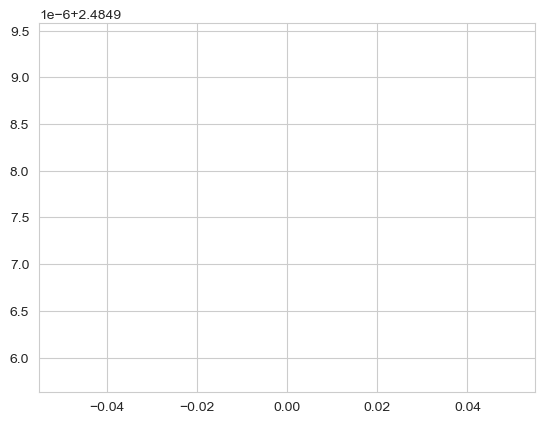

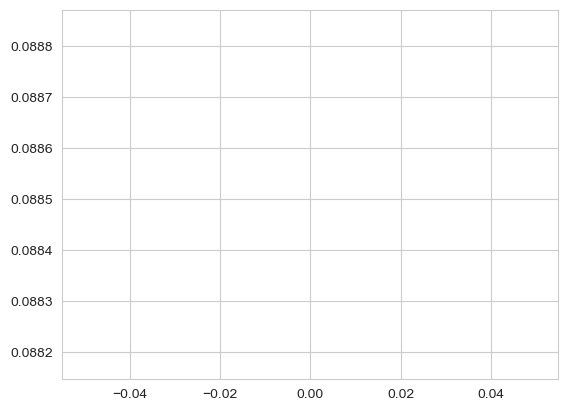

[002/100] Train Acc: 0.089826 Loss: 2.484787 | Val Acc: 0.085714 loss: 2.484931
[003/100] Train Acc: 0.104336 Loss: 2.482152 | Val Acc: 0.085045 loss: 2.485368
[004/100] Train Acc: 0.119684 Loss: 2.476439 | Val Acc: 0.084375 loss: 2.486167
[005/100] Train Acc: 0.134111 Loss: 2.468631 | Val Acc: 0.085938 loss: 2.487114
[006/100] Train Acc: 0.146975 Loss: 2.459775 | Val Acc: 0.084821 loss: 2.488155
[007/100] Train Acc: 0.157607 Loss: 2.450117 | Val Acc: 0.084598 loss: 2.489280
[008/100] Train Acc: 0.167653 Loss: 2.439865 | Val Acc: 0.083482 loss: 2.490525
[009/100] Train Acc: 0.176108 Loss: 2.429287 | Val Acc: 0.084598 loss: 2.492097
[010/100] Train Acc: 0.182917 Loss: 2.418638 | Val Acc: 0.084375 loss: 2.493752
[011/100] Train Acc: 0.189335 Loss: 2.408031 | Val Acc: 0.084821 loss: 2.495489


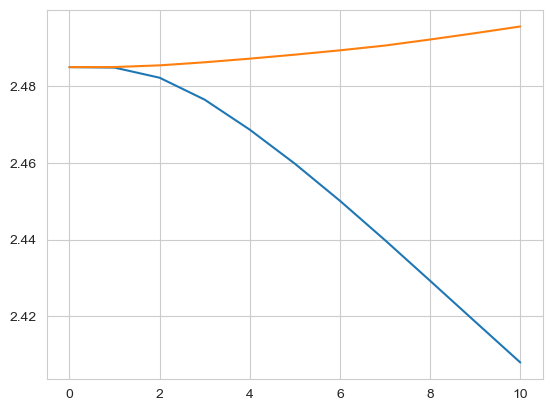

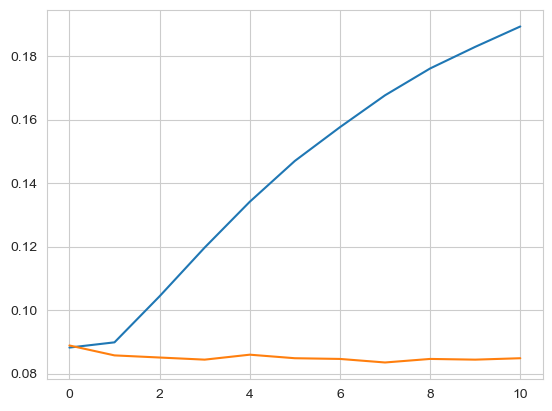

[012/100] Train Acc: 0.193911 Loss: 2.397639 | Val Acc: 0.083929 loss: 2.497457
[013/100] Train Acc: 0.199046 Loss: 2.387448 | Val Acc: 0.083259 loss: 2.499592
[014/100] Train Acc: 0.202450 Loss: 2.377407 | Val Acc: 0.082812 loss: 2.501646
[015/100] Train Acc: 0.206022 Loss: 2.367623 | Val Acc: 0.081696 loss: 2.503775
[016/100] Train Acc: 0.209064 Loss: 2.358065 | Val Acc: 0.081920 loss: 2.505895
[017/100] Train Acc: 0.212691 Loss: 2.348731 | Val Acc: 0.082589 loss: 2.507962
[018/100] Train Acc: 0.215565 Loss: 2.339648 | Val Acc: 0.082366 loss: 2.510057
[019/100] Train Acc: 0.217826 Loss: 2.330860 | Val Acc: 0.082589 loss: 2.512156
[020/100] Train Acc: 0.220477 Loss: 2.322372 | Val Acc: 0.081473 loss: 2.514215
[021/100] Train Acc: 0.222318 Loss: 2.314154 | Val Acc: 0.080804 loss: 2.516309


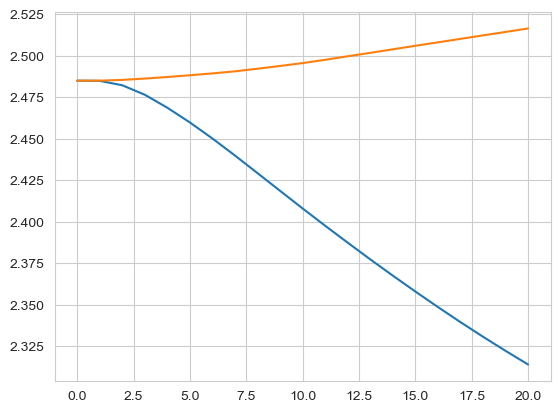

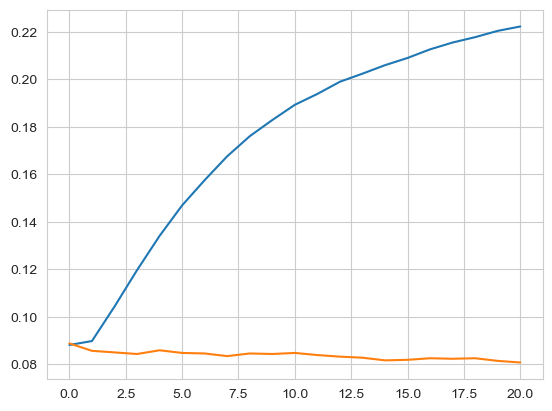

[022/100] Train Acc: 0.224021 Loss: 2.306166 | Val Acc: 0.080580 loss: 2.518416
[023/100] Train Acc: 0.226420 Loss: 2.298426 | Val Acc: 0.083036 loss: 2.520514
[024/100] Train Acc: 0.228178 Loss: 2.290923 | Val Acc: 0.081920 loss: 2.522574
[025/100] Train Acc: 0.230271 Loss: 2.283656 | Val Acc: 0.081473 loss: 2.524605
[026/100] Train Acc: 0.231360 Loss: 2.276630 | Val Acc: 0.081250 loss: 2.526588
[027/100] Train Acc: 0.233201 Loss: 2.269839 | Val Acc: 0.080580 loss: 2.528613
[028/100] Train Acc: 0.234569 Loss: 2.263276 | Val Acc: 0.081696 loss: 2.530563
[029/100] Train Acc: 0.235657 Loss: 2.256931 | Val Acc: 0.080134 loss: 2.532486
[030/100] Train Acc: 0.237415 Loss: 2.250779 | Val Acc: 0.080134 loss: 2.534487
[031/100] Train Acc: 0.238894 Loss: 2.244863 | Val Acc: 0.080804 loss: 2.536454


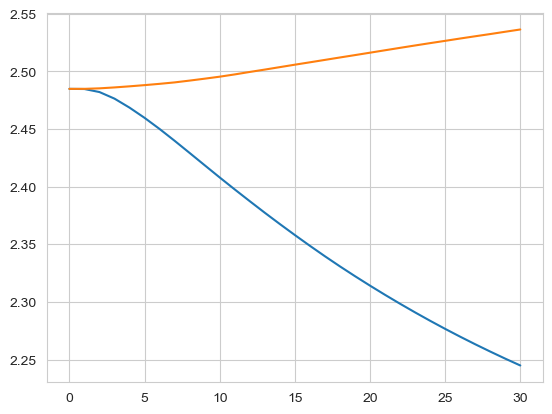

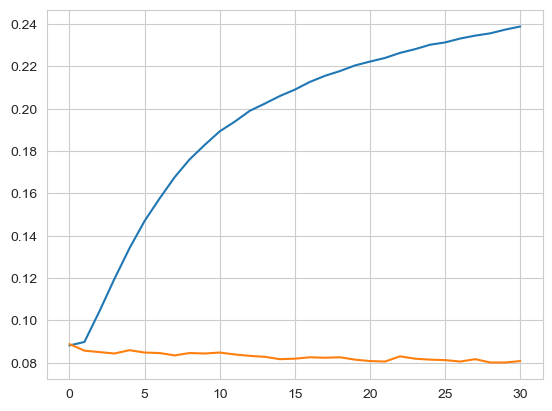

[032/100] Train Acc: 0.239926 Loss: 2.239120 | Val Acc: 0.081696 loss: 2.538398
[033/100] Train Acc: 0.241461 Loss: 2.233567 | Val Acc: 0.081027 loss: 2.540298
[034/100] Train Acc: 0.242689 Loss: 2.228189 | Val Acc: 0.079687 loss: 2.542167
[035/100] Train Acc: 0.243638 Loss: 2.222993 | Val Acc: 0.080804 loss: 2.543999
[036/100] Train Acc: 0.244614 Loss: 2.217944 | Val Acc: 0.080134 loss: 2.545776
[037/100] Train Acc: 0.245814 Loss: 2.213058 | Val Acc: 0.080804 loss: 2.547534
[038/100] Train Acc: 0.246540 Loss: 2.208331 | Val Acc: 0.080580 loss: 2.549233
[039/100] Train Acc: 0.247823 Loss: 2.203738 | Val Acc: 0.080804 loss: 2.550927
[040/100] Train Acc: 0.248828 Loss: 2.199280 | Val Acc: 0.080134 loss: 2.552648
[041/100] Train Acc: 0.249302 Loss: 2.194937 | Val Acc: 0.079911 loss: 2.554269


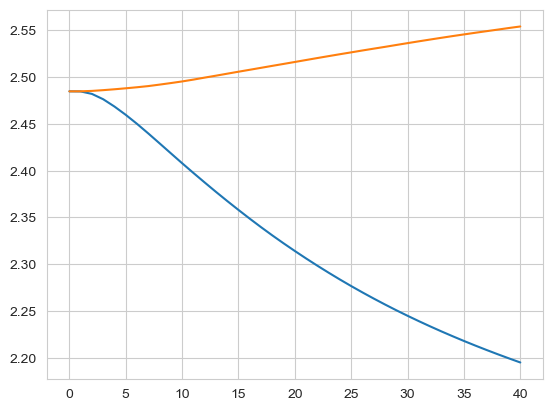

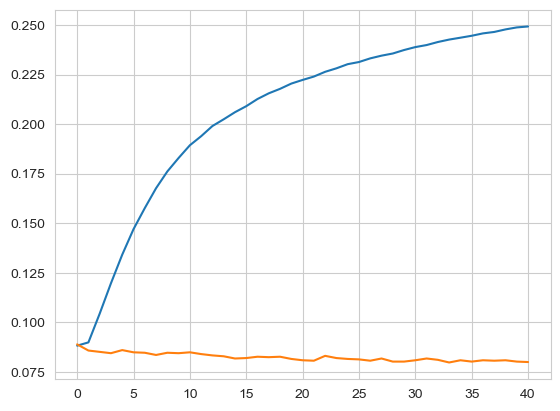

[042/100] Train Acc: 0.250223 Loss: 2.190720 | Val Acc: 0.080134 loss: 2.555905
[043/100] Train Acc: 0.251284 Loss: 2.186617 | Val Acc: 0.080134 loss: 2.557561
[044/100] Train Acc: 0.252204 Loss: 2.182627 | Val Acc: 0.080357 loss: 2.559207
[045/100] Train Acc: 0.252735 Loss: 2.178744 | Val Acc: 0.080580 loss: 2.560807
[046/100] Train Acc: 0.253683 Loss: 2.174967 | Val Acc: 0.080804 loss: 2.562354
[047/100] Train Acc: 0.257451 Loss: 2.170599 | Val Acc: 0.080134 loss: 2.561187
[048/100] Train Acc: 0.262222 Loss: 2.162011 | Val Acc: 0.078571 loss: 2.562313
[049/100] Train Acc: 0.266464 Loss: 2.154486 | Val Acc: 0.079464 loss: 2.563992
[050/100] Train Acc: 0.270454 Loss: 2.147789 | Val Acc: 0.080804 loss: 2.565824
[051/100] Train Acc: 0.273245 Loss: 2.141535 | Val Acc: 0.080804 loss: 2.567765


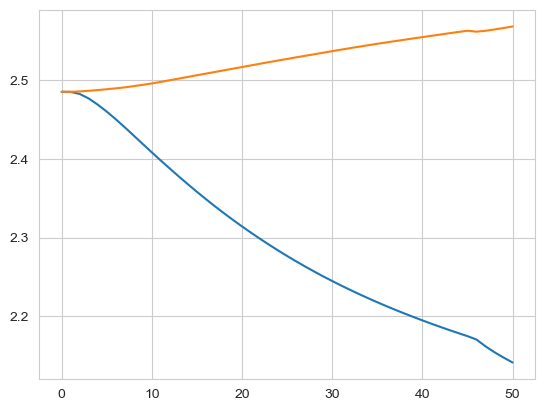

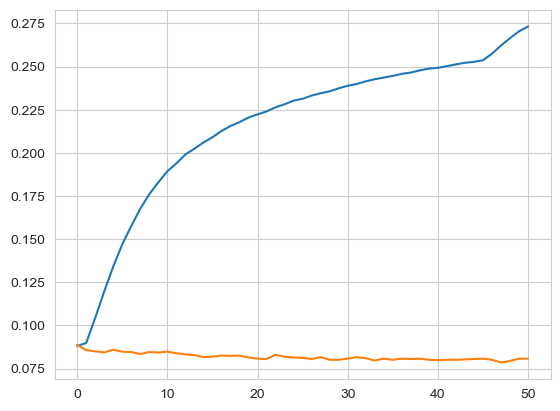

[052/100] Train Acc: 0.276091 Loss: 2.135577 | Val Acc: 0.080357 loss: 2.569739
[053/100] Train Acc: 0.277793 Loss: 2.129896 | Val Acc: 0.078125 loss: 2.571843
[054/100] Train Acc: 0.279468 Loss: 2.124461 | Val Acc: 0.078571 loss: 2.573807
[055/100] Train Acc: 0.281393 Loss: 2.119237 | Val Acc: 0.079464 loss: 2.575879
[056/100] Train Acc: 0.283374 Loss: 2.114211 | Val Acc: 0.079241 loss: 2.577893
[057/100] Train Acc: 0.284574 Loss: 2.109365 | Val Acc: 0.078795 loss: 2.579974
[058/100] Train Acc: 0.286304 Loss: 2.104679 | Val Acc: 0.078795 loss: 2.581926
[059/100] Train Acc: 0.287225 Loss: 2.100155 | Val Acc: 0.078348 loss: 2.583859
[060/100] Train Acc: 0.287839 Loss: 2.095764 | Val Acc: 0.078348 loss: 2.585785
[061/100] Train Acc: 0.289569 Loss: 2.091517 | Val Acc: 0.077902 loss: 2.587643


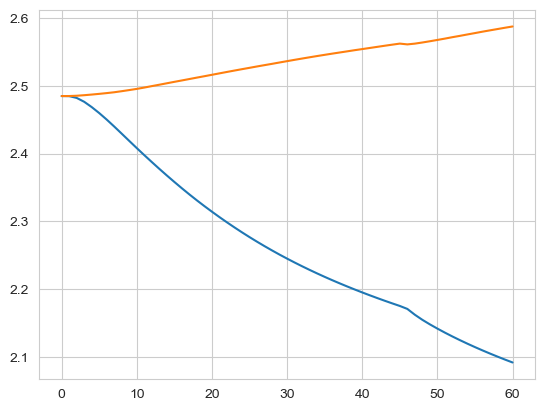

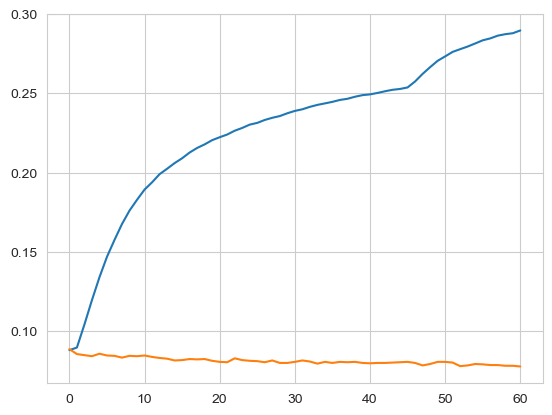

[062/100] Train Acc: 0.290462 Loss: 2.087408 | Val Acc: 0.077902 loss: 2.589498
[063/100] Train Acc: 0.291522 Loss: 2.083421 | Val Acc: 0.077902 loss: 2.591303
[064/100] Train Acc: 0.292388 Loss: 2.079554 | Val Acc: 0.077902 loss: 2.593052
[065/100] Train Acc: 0.293839 Loss: 2.075793 | Val Acc: 0.078125 loss: 2.594814
[066/100] Train Acc: 0.293867 Loss: 2.072122 | Val Acc: 0.078125 loss: 2.596595
[067/100] Train Acc: 0.295513 Loss: 2.068564 | Val Acc: 0.078795 loss: 2.598356
[068/100] Train Acc: 0.296183 Loss: 2.065108 | Val Acc: 0.079241 loss: 2.600076
[069/100] Train Acc: 0.296880 Loss: 2.061741 | Val Acc: 0.079464 loss: 2.601781
[070/100] Train Acc: 0.298945 Loss: 2.058123 | Val Acc: 0.078571 loss: 2.601222
[071/100] Train Acc: 0.304694 Loss: 2.050768 | Val Acc: 0.081920 loss: 2.601288


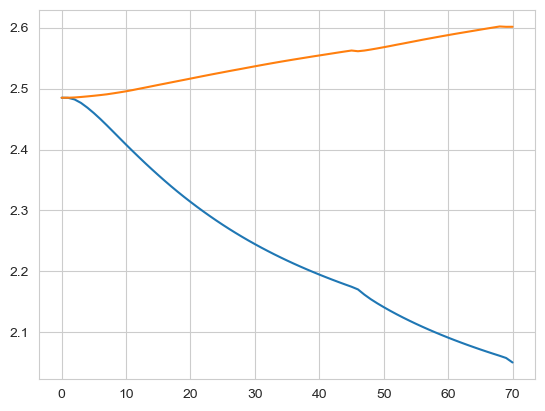

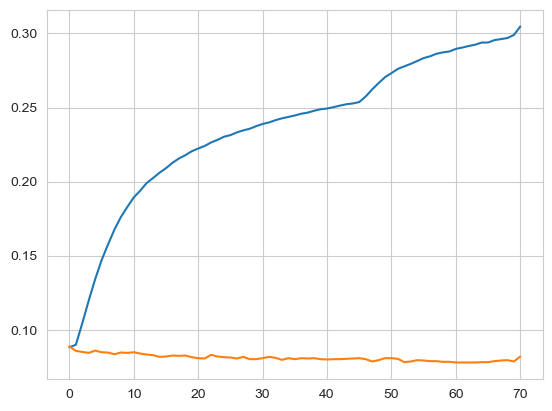

[072/100] Train Acc: 0.310944 Loss: 2.042342 | Val Acc: 0.082143 loss: 2.602803
[073/100] Train Acc: 0.316079 Loss: 2.035491 | Val Acc: 0.081027 loss: 2.604574
[074/100] Train Acc: 0.319595 Loss: 2.029161 | Val Acc: 0.082366 loss: 2.606491
[075/100] Train Acc: 0.322385 Loss: 2.023158 | Val Acc: 0.081920 loss: 2.608479
[076/100] Train Acc: 0.324701 Loss: 2.017458 | Val Acc: 0.080357 loss: 2.610554
[077/100] Train Acc: 0.327576 Loss: 2.011982 | Val Acc: 0.081027 loss: 2.612643
[078/100] Train Acc: 0.329529 Loss: 2.006730 | Val Acc: 0.080804 loss: 2.614683
[079/100] Train Acc: 0.331315 Loss: 2.001682 | Val Acc: 0.081250 loss: 2.616711
[080/100] Train Acc: 0.332905 Loss: 1.996815 | Val Acc: 0.081027 loss: 2.618750
[081/100] Train Acc: 0.334663 Loss: 1.992113 | Val Acc: 0.080804 loss: 2.620853


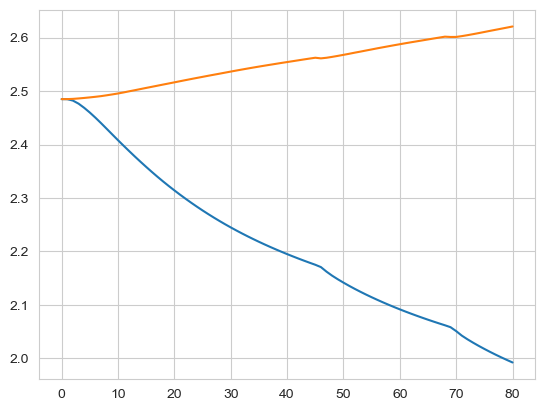

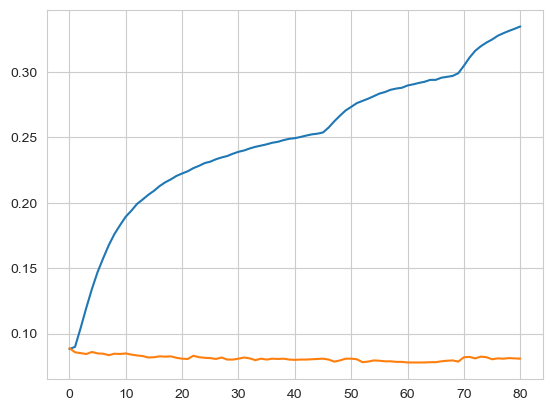

[082/100] Train Acc: 0.336003 Loss: 1.987555 | Val Acc: 0.080804 loss: 2.622815
[083/100] Train Acc: 0.337510 Loss: 1.983127 | Val Acc: 0.080580 loss: 2.624823
[084/100] Train Acc: 0.339631 Loss: 1.978827 | Val Acc: 0.080134 loss: 2.626978
[085/100] Train Acc: 0.339742 Loss: 1.974668 | Val Acc: 0.080804 loss: 2.628893
[086/100] Train Acc: 0.341779 Loss: 1.970634 | Val Acc: 0.080804 loss: 2.630927
[087/100] Train Acc: 0.341472 Loss: 1.966717 | Val Acc: 0.081473 loss: 2.632924
[088/100] Train Acc: 0.343565 Loss: 1.962897 | Val Acc: 0.081250 loss: 2.634870
[089/100] Train Acc: 0.344319 Loss: 1.959163 | Val Acc: 0.081027 loss: 2.636896
[090/100] Train Acc: 0.344235 Loss: 1.955540 | Val Acc: 0.081696 loss: 2.638904
[091/100] Train Acc: 0.346384 Loss: 1.952016 | Val Acc: 0.081920 loss: 2.640806


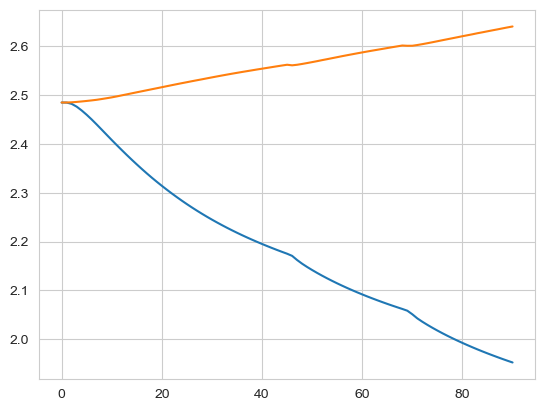

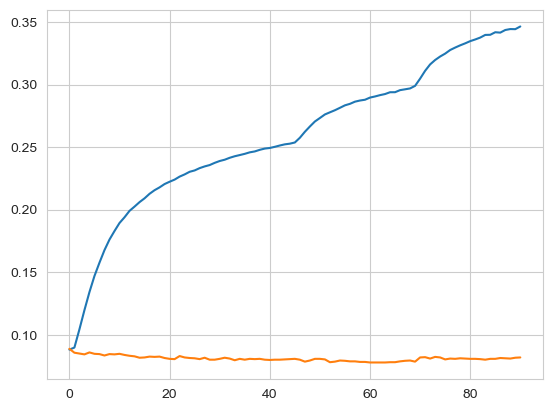

[092/100] Train Acc: 0.347137 Loss: 1.948588 | Val Acc: 0.082812 loss: 2.642625
[093/100] Train Acc: 0.347416 Loss: 1.945227 | Val Acc: 0.082366 loss: 2.644474
[094/100] Train Acc: 0.348728 Loss: 1.941972 | Val Acc: 0.082366 loss: 2.646413
[095/100] Train Acc: 0.348672 Loss: 1.938779 | Val Acc: 0.082589 loss: 2.648238
[096/100] Train Acc: 0.349844 Loss: 1.935653 | Val Acc: 0.082589 loss: 2.649986
[097/100] Train Acc: 0.350374 Loss: 1.932610 | Val Acc: 0.082143 loss: 2.651792
[098/100] Train Acc: 0.351351 Loss: 1.929635 | Val Acc: 0.082143 loss: 2.653668
[099/100] Train Acc: 0.351909 Loss: 1.926725 | Val Acc: 0.082143 loss: 2.655455
[100/100] Train Acc: 0.352188 Loss: 1.923873 | Val Acc: 0.082366 loss: 2.657151


NameError: name 'valid_set_size' is not defined

In [4]:

for essay in range(0, 1):
    # with open(rf"../embeddings/transformer/transformer_essay{essay}.pickle", "rb") as input_file:
    #     e = cPickle.load(input_file)
    # 
    # x_df = e
    # 
    # 
    # total = y.shape[0]
    # VAL_RATIO = 0.1
    # TEST_RATIO = 0.1
    # train_set_size = int(total * (1 - VAL_RATIO - TEST_RATIO))
    # valid_set_size = int(total * VAL_RATIO)
    # test_set_size = total - train_set_size - valid_set_size

    
    
    dataset_test = EssayDataset(torch.from_numpy(np.array(X_test.toarray())).to(device).float(), torch.from_numpy(np.array(y_test)).to(device).long())
    
    
    
    dataset_val = EssayDataset(torch.from_numpy(np.array(X_val.toarray())).to(device).float(), torch.from_numpy(np.array(y_val)).to(device).long())

    dataset = EssayDataset(torch.from_numpy(np.array(X_train.toarray())).to(device).float(), torch.from_numpy(np.array(y_train)).to(device).long())


    BATCH_SIZE = config['batch_size']

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0)
    val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=0)
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=0)
    train_samples = len(train_loader.dataset)
    val_samples = len(val_loader.dataset)
    test_samples = len(test_loader.dataset)
    total = train_samples + val_samples + test_samples
    total_samples = train_samples
    print(f'total: {total}, train: {train_samples}, val: {val_samples}, test: {test_samples}')
    # print_proportions(train_loader,val_loader, test_loader)
    n_iterations = math.ceil(total_samples / BATCH_SIZE)


    # fix random seed for reproducibility
    same_seeds(2022)

    # training parameters
    num_epoch = config['n_epochs']
    # num_inputs, num_channels, kernel_sizes, dilation_sizes, dropouts, window_size
    from baseline_nn_model import MLP

    model = MLP(len(encoding))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    list(model.parameters())

    best_acc = 0.0
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epoch):
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0

        # training
        model.train()  # set the model to training mode
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs.float())
            batch_loss = criterion(outputs, labels)

            _, train_pred = torch.max(outputs, 1)  # get the index of the class with the highest probability
            batch_loss.backward()
            optimizer.step()

            train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
            train_loss += batch_loss.item()


        # validation
        if val_samples > 0:
            model.eval()  # set the model to evaluation mode
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())
                    batch_loss = criterion(outputs, labels)
                    _, val_pred = torch.max(outputs, 1)

                    val_acc += (
                            val_pred.cpu() == labels.cpu()).sum().item()  # get the index of the class with the highest probability
                    val_loss += batch_loss.item()

                print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                    epoch + 1, num_epoch, train_acc / train_samples, train_loss / len(train_loader),
                    val_acc / val_samples, val_loss / len(val_loader)
                ))

                train_accs.append(train_acc / train_samples)
                val_accs.append(val_acc / val_samples)
                train_losses.append(train_loss / len(train_loader))
                val_losses.append(val_loss / len(val_loader))

                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model.state_dict(), model_path)
                    print('saving model with acc {:.3f}'.format(best_acc / val_samples))
        else:
            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc / train_samples, train_loss / len(train_loader)
            ))

        if epoch % 10 == 0:
            plt.plot(train_losses, label='Train Loss')
            plt.plot(val_losses, label='Val loss')
            plt.legend(loc='best')
            plt.show()

            plt.plot(train_accs, label= 'Train Acc')
            plt.plot(val_accs, label= 'Val Acc')
            plt.legend(loc='best')
            plt.savefig(f'../plots/baseline_{essay}.png')
            plt.show()

    # if not validating, save the last epoch
    # if valid_set_size == 0:
    #     torch.save(model.state_dict(), model_path)
    #     print('saving model at last epoch')

    pt = torch.load(model_path, map_location=device)
    model.load_state_dict(pt)

    test_acc = 0
    test_loss = 0
    model.eval()
    y_pred = []
    y_test = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            batch_loss = criterion(outputs, labels)
            _, test_pred = torch.max(outputs, 1)
            y_pred += test_pred.tolist()
            y_test += labels.tolist()
            test_acc += (
                    test_pred.cpu() == labels.cpu()).sum().item()  # get the index of the class with the highest probability
            test_loss += batch_loss.item()

        print(test_acc / test_samples)
    # with open(csv_path, "a") as f:
    #     f.write(
    #         f'{t},{channels},{train_acc / train_samples},{val_acc / val_samples},{test_acc / test_samples},{total}\n')



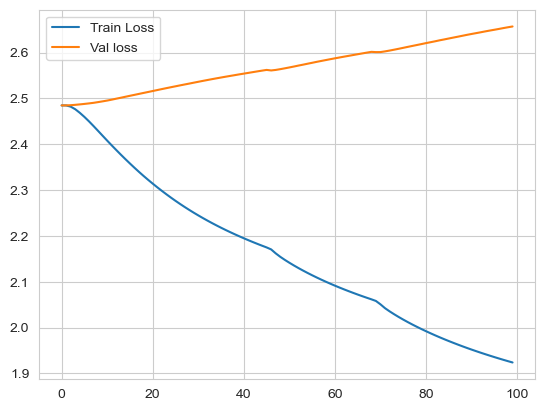

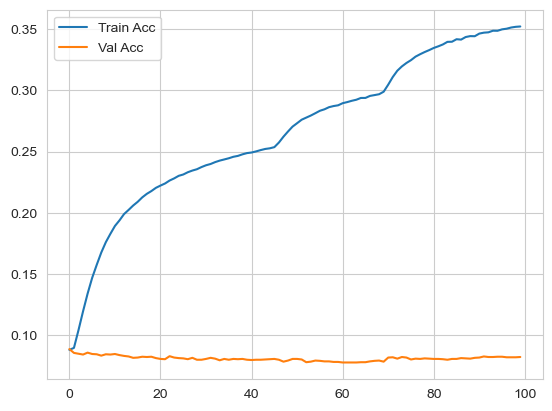

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val loss')
plt.legend(loc='best')
plt.show()

plt.plot(train_accs, label= 'Train Acc')
plt.plot(val_accs, label= 'Val Acc')
plt.legend(loc='best')
plt.savefig(f'../plots/baseline_{essay}.png')
plt.show()

In [6]:

pt = torch.load(model_path, map_location=device)
model.load_state_dict(pt)

test_acc = 0
test_loss = 0
model.eval()
y_pred = []
y_test = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.float())
        batch_loss = criterion(outputs, labels)
        _, test_pred = torch.max(outputs, 1)
        y_pred += test_pred.tolist()
        y_test += labels.tolist()
        test_acc += (
                test_pred.cpu() == labels.cpu()).sum().item()  # get the index of the class with the highest probability
        test_loss += batch_loss.item()

    print(test_acc / test_samples)
# with open(csv_path, "a") as f:
#     f.write(
#         f'{t},{channels},{train_acc / train_samples},{val_acc / val_samples},{test_acc / test_samples},{total}\n')



0.08816964285714286


/Users/jimmy/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jimmy/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jimmy/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

              precision    recall  f1-score   support

           0       0.09      0.99      0.16       397
           1       0.00      0.00      0.00       383
           2       0.00      0.00      0.00       362
           3       0.00      0.00      0.00       358
           4       0.00      0.00      0.00       378
           5       0.00      0.00      0.00       381
           6       0.00      0.00      0.00       363
           7       0.00      0.00      0.00       401
           8       0.00      0.00      0.00       367
           9       0.00      0.00      0.00       387
          10       0.00      0.00      0.00       378
          11       0.00      0.00      0.00       325

    accuracy                           0.09      4480
   macro avg       0.01      0.08      0.01      4480
weighted avg       0.01      0.09      0.01      4480


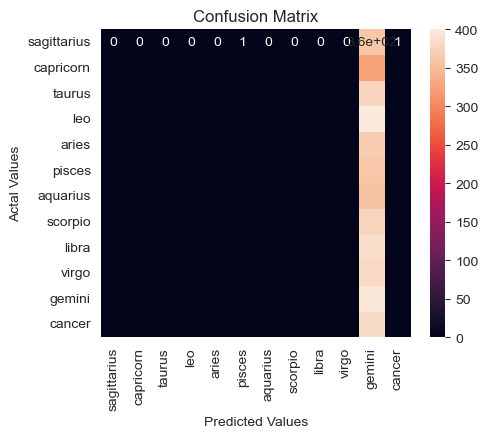

In [8]:
# Sample dictionary

# Reverse key-value pairs
reversed_labels = {count: label for label, count in encoding.items()}

def reverse_label(x):
    return reversed_labels[x]
#Plotting the confusion matrix
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
y_pred2 = list(map(reverse_label, y_pred))
y_test2 = list(map(reverse_label, y_test))
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, classification_report
cm2 = confusion_matrix(y_test2, y_pred2, labels=list(set(encoding)))
import matplotlib.pyplot as plt
import seaborn as sns

cm_df2 = pd.DataFrame(cm2,
                      index =list(set(encoding)),
                      columns = list(set(encoding)))
plt.figure(figsize=(5,4))
sns.heatmap(cm_df2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()